# Basic RNA circuit simulation 

Use the `synbio_morpher` package to simulate some RNA circuits.



In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from bioreaction.simulation.basic_sim import convert_model

import jax
import numpy as np
import pandas as pd
import os
import sys
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-paper')
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.common.setup import prepare_config, construct_circuit_from_cfg
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.evolution.evolver import load_mutations
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.common.testing.shared import five_circuits
from synbio_morpher.utils.results.analytics.timeseries import compute_sensitivity, compute_precision, calculate_adaptation

config = load_json_as_dict('../synbio_morpher/utils/common/testing/configs/simple_circuit.json')


Ignore the below 2 blocks

In [3]:
def calculate_precision(output_diff, starting_states, signal_diff, signal_0) -> np.ndarray:
    denom = np.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = np.where((starting_states != 0).astype(int),
                      output_diff / starting_states, 1)
    precision = np.absolute(np.divide(
        numer, denom))
    return np.divide(1, precision)


def get_precision(signal_idx: int, starting_states, steady_states):
    if signal_idx is None:
        return None
    signal_0 = starting_states[signal_idx]
    signal_1 = steady_states[signal_idx]

    signal_diff = signal_1 - signal_0
    output_diff = steady_states - starting_states

    return calculate_precision(output_diff, starting_states, signal_diff, signal_0)


final, initial, signal_f, signal_i = (173.34004, 157.3838, 419.0314, 76.26714)
signal_diff = signal_f - signal_i
output_diff = final - initial
calculate_precision(output_diff, np.expand_dims(initial, axis=0), signal_diff, signal_i)
denom = np.where(signal_i != 0, signal_diff / signal_i, 1)

numer = np.where((np.expand_dims(initial, axis=0) != 0).astype(int),
                    output_diff / initial, 1)


In [4]:
def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else: # unbound RNA -> bound RNA
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    return inputs, outputs, forward_rates, reverse_rates, m

# Set parameters

Use the 5 tester circuits :)

In [5]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['use_initial_to_add_signal'] = False
config['simulation']['use_rate_scaling'] = True
config['simulation']['device'] = 'cpu'
config['simulation']['t1'] = 500
config['simulation']['tmax'] = 1500
config['simulation']['interaction_factor'] = 1
config['signal']['function_kwargs']['target'] = 2

q = 1
p = 1
config['molecular_params_factor'] = p
config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * q
config['molecular_params']['creation_rate' + '_per_molecule'] = config['molecular_params']['creation_rate' + '_per_molecule'] * q
# config['simulation']['dt0'] = 0.1
# config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * p
# config['molecular_params']['degradation_rate'] = config['molecular_params']['degradation_rate'] * p

In [6]:
circuits, config, result_writer = five_circuits(config)


xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [7]:
config['interaction_simulator']['simulator_kwargs']['threads'] = 8

In [8]:
def load_circuit(top_dir, circuit_name, config):
    dp = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(top_dir, 'binding_rates_dissociation', circuit_name + '_' + 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(top_dir, 'eqconstants', circuit_name + '_' + 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}

    return construct_circuit_from_cfg({
        'data_path': dp,
        'interactions': interactions
    }, config)


# tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#              circuit_name='toy_mRNA_circuit_1844', config=config)


# tester_circuits = []
# for name in ['toy_mRNA_circuit_21566', 'toy_mRNA_circuit_24706', 'toy_mRNA_circuit_19768', 'toy_mRNA_circuit_2983', 'toy_mRNA_circuit_22658']:
#     fn = os.path.join('..', 'data/ensemble_mutation_effect_analysis/2023_04_11_192013/mutation_effect_on_interactions_signal', name, 'mutations.csv')
#     tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#                                         circuit_name=name, config=config)
#     tester_circuit = load_mutations(tester_circuit, fn)
#     tester_circuits.append(tester_circuit)

# config['interactions'] = {}
# config['interactions'] = None
# tester_circuit = construct_circuit_from_cfg(
#     {'data_path': '../tester.fasta'}, config)
# [circuits.append(tester_circuit) for tester_circuit in tester_circuits]


# Load fake circuits

In [9]:
def load_fake_circuit(eqconstants):
    pdir = '../'
    top_dir = 'data/ensemble_mutation_effect_analysis/2024_11_09_164634/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_0'
    some_circuit = os.path.join(pdir, top_dir, 'circuits', circuit_name + '.fasta')

    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    binding_rates_dissociation = eqconstant_to_rates(eqconstants, k_a)[1]

    labels = ['RNA_0', 'RNA_1', 'RNA_2']
    pd.DataFrame(eqconstants, columns=labels, index=labels).to_csv(
        'eqconstants.csv', index=None)
    pd.DataFrame(binding_rates_dissociation, columns=labels, index=labels).to_csv('binding_rates_dissociation.csv', index=None)

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(pdir, 'explanations', 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(pdir, 'explanations', 'eqconstants' + '.csv'),
                    'energies': os.path.join(pdir, top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(pdir, top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions': interactions
    }, config)


eqconstants_4337 = np.array([[1e2, 1e2, 5e0],
                             [1e2, 1e-02, 1e2],
                             [5e0, 1e2, 1e-02]])

# tester_circuit = load_fake_circuit(eqconstants_4337)
tester_circuit1 = load_fake_circuit(np.ones((3,3)))
tester_circuit1.name = 'K_1'
tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0.5)
tester_circuit2.name = 'K_05'
# tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0)
# tester_circuit2.name = 'K_0'

circuits.append(tester_circuit1)
circuits.append(tester_circuit2)



interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/eqconstants.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():149: Could not find circuit name in ../explanations/eqconstants.csv WARNING


### Throw in some more fake circuits

In [10]:
def load_fake_circuit2(energies):
    pdir = '../'
    top_dir = 'data/ensemble_mutation_effect_analysis/2024_11_09_164634/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_0'
    some_circuit = os.path.join(pdir, top_dir, 'circuits', circuit_name + '.fasta')
    N0 = config['molecular_params']['starting_copynumbers'] 
    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    eqconstants = equilibrium_constant_reparameterisation(energies, initial=N0)
    binding_rates_dissociation = eqconstant_to_rates(eqconstants, k_a)[1]

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'] * np.ones((3,3)),
                    'binding_rates_dissociation': binding_rates_dissociation,
                    'eqconstants': eqconstants,
                    'energies': energies,
                    'binding_sites': None}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions_loaded': interactions,
        'interactions': None
    }, config)

n_extra_fakes = 30
energies = np.random.rand(n_extra_fakes, 3, 3)
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
for i, e in enumerate(energies):
    e[np.tril_indices(3)] = e.T[np.tril_indices(3)]
    energies[i] = e
    circuits.append(load_fake_circuit2(e))
    circuits[-1].name = f'rand_{i}'

array([[-21.74199543, -23.81741015,  -6.97165607],
       [-23.81741015, -15.79767739, -15.80468062],
       [ -6.97165607, -15.80468062, -16.40855032]])

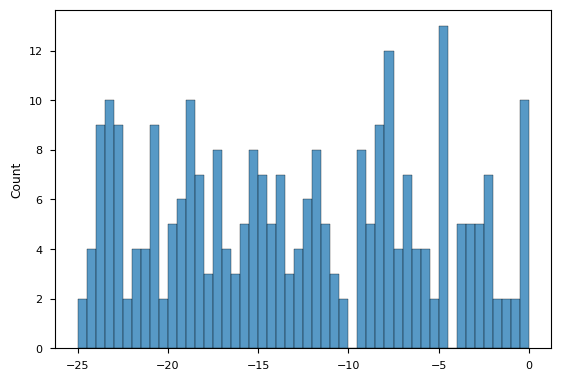

In [11]:
sns.histplot(energies.flatten(), bins=50)
# sns.histplot((eqconstant_to_rates(eqconstants, k_a)[1]).flatten(), bins=50)
e

<Axes: ylabel='Count'>

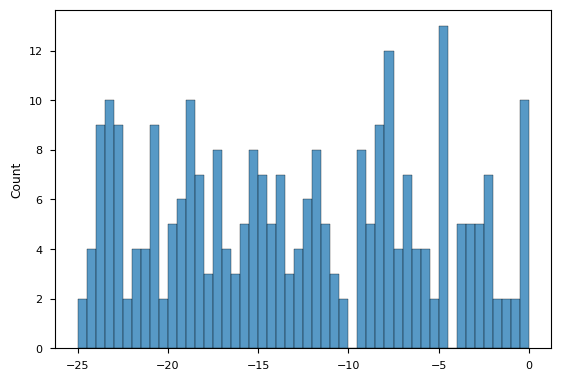

In [12]:
sns.histplot(np.concat([c.interactions.energies for c in circuits[-n_extra_fakes:]]).flatten(), bins=50)


In [13]:
config['molecular_params']['association_binding_rate' + '_per_molecule']

np.float64(0.00150958097)

In [14]:
# for c in circuits:
#     c.reset_to_initial_state()

# Run interaction simulation

In [15]:
circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, methods={"compute_interactions": {}},
    batch_size=config['simulation']['batch_size'])
i = -1


circuit_manager.py:batch_circuits():600: 	From 37 circuits, a total of 37 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 37 / 37) WARNING
circuit_manager.py:batch_circuits():627: 		Making subcircuits 0 - 37 took 6.6e-05s WARNING
circuit_manager.py:batch_circuits():633: 	Batching 0 - 100 circuits (out of 0 - 37 (total: 37)) (Circuits: 0 - 37 of 37) WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: compute_interactions WARNING


circuit_manager.py:run_batch():701: 		Method compute_interactions took 0.106244s WARNING
circuit_manager.py:batch_circuits():647: Single batch: 0:00:00.108570 
Projected time: 0.10856999999999999s 
Total time: 0:00:00.108582 WARNING


'loaded'

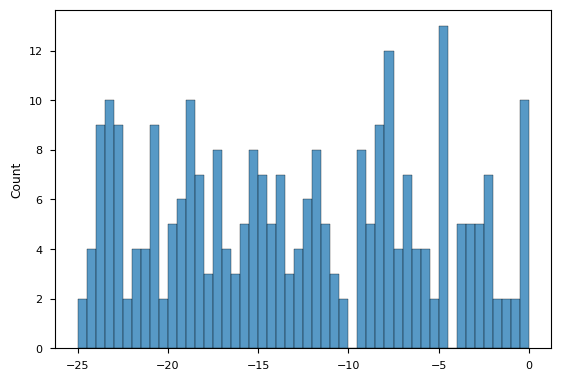

In [16]:
sns.histplot(np.concat([c.interactions.energies for c in circuits[-n_extra_fakes:]]).flatten(), bins=50)

circuits[-1].interactions_state

In [17]:
circuits[i].interactions.binding_rates_dissociation

Array([[2.5136178e-05, 4.7777821e-06, 3.4044023e+00],
       [4.7777821e-06, 2.9212376e-03, 2.9049173e-03],
       [3.4044023e+00, 2.9049173e-03, 1.7919588e-03]], dtype=float32)

In [18]:
circuits[i].interactions.binding_rates_association

array([[0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958]])

In [19]:
config['molecular_params']['creation_rate']

2.35

In [20]:
config['molecular_params']['degradation_rate']


0.01175

# Run dynamic simulation

In [21]:
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, 
    batch_size=config['simulation']['batch_size'],
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        'simulate_signal_batch': {'ref_circuit': None,
                                  'batch': config['simulation']['use_batch_mutations']},
        'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
                          'no_numerical': False} #config['experiment']['no_numerical']}
    }
)

circuit_manager.py:batch_circuits():600: 	From 37 circuits, a total of 37 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 37 / 37) WARNING
circuit_manager.py:batch_circuits():627: 		Making subcircuits 0 - 37 took 4.4e-05s WARNING
circuit_manager.py:batch_circuits():633: 	Batching 0 - 100 circuits (out of 0 - 37 (total: 37)) (Circuits: 0 - 37 of 37) WARNING
circuit_manager.py:run_batch():665: 		Running 37 Subcircuits - 0_weak: init_circuits WARNING


EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/usr/local/lib/python3.11/dist-packages/diffrax/_integrate.py", line 1423, in diffeqsolve
    sol = result.error_if(sol, jnp.invert(is_okay(result)))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
equinox.EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


# Plot results

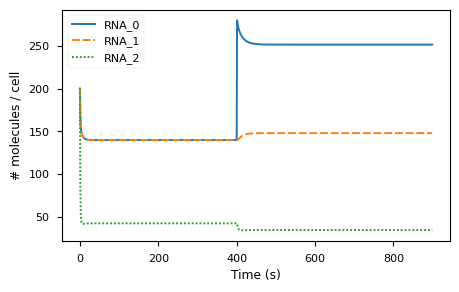

In [ ]:
chosen_circuit = circuits[1]
data_fn_ste = os.path.join(result_writer.write_dir, chosen_circuit.name, 'steady_states_data.csv')
data_fn_sig = os.path.join(result_writer.write_dir, chosen_circuit.name, 'signal_data.csv')
data = pd.concat([
    pd.read_csv(data_fn_ste, names=sorted([s.name for s in chosen_circuit.model.species])),
    pd.read_csv(data_fn_sig, names=sorted([s.name for s in chosen_circuit.model.species]))
]).reset_index()

plt.figure(figsize=(5,3))
sns.lineplot(data[sorted([s.name for s in chosen_circuit.get_input_species()])])
plt.ylabel('# molecules / cell')
plt.xlabel('Time (s)')
plt.savefig('output/circ4.svg')


In [ ]:
all_df = pd.DataFrame()
for c in circuits:
    analytics_fn_sig = os.path.join(result_writer.write_dir, c.name, 'report_signal.json')
    df = pd.DataFrame().from_dict(load_json_as_dict(analytics_fn_sig))
    df = df.apply(pd.to_numeric, errors='coerce')
    df['sample_name'] = [s.name for s in c.model.species]
    df['name'] = c.name
    df = df[['name'] + list(df.columns[:-1])]
    all_df = pd.concat([all_df, df])
all_df

,name,fold_change,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,0_weak,3.989323,0.066913,0.266938,0.066913,2.980232e-08,0.0,0.266938,0.00000,0.334524,2.989323,"('RNA_0', 'RNA_0')"
1,0_weak,1.996664,0.066913,0.133603,0.066913,1.490116e-08,0.0,0.133603,0.00000,1.003348,0.996664,"('RNA_0', 'RNA_1')"
2,0_weak,1.996664,0.066913,0.133603,0.066913,1.490116e-08,0.0,0.133603,0.00000,1.003348,0.996664,"('RNA_0', 'RNA_2')"
3,0_weak,0.999334,0.066913,0.066913,0.066869,0.000000e+00,0.0,0.066869,inf,1500.572500,0.000666,"('RNA_1', 'RNA_1')"
4,0_weak,0.999334,0.066913,0.066913,0.066869,0.000000e+00,0.0,0.066869,inf,1500.572500,0.000666,"('RNA_1', 'RNA_2')"
...,...,...,...,...,...,...,...,...,...,...,...,...
4,rand_29,0.989778,98.027450,98.027450,97.025420,0.000000e+00,0.0,97.025420,179.95992,97.828920,0.010222,"('RNA_1', 'RNA_2')"
5,rand_29,0.090497,0.000385,0.000385,0.000035,0.000000e+00,0.0,0.000035,198.39679,1.099501,0.909503,"('RNA_2', 'RNA_2')"
6,rand_29,1.949066,94.099620,188.199230,94.099620,4.792908e+00,0.0,183.406330,158.71744,1.053668,1.000000,RNA_0
7,rand_29,0.971872,95.188545,95.188545,91.603645,9.074249e-01,0.0,92.511070,179.15831,35.551610,0.037661,RNA_1


In [ ]:
all_df['adaptability'] = calculate_adaptation(all_df['sensitivity_wrt_species-6'].to_numpy(), all_df['precision_wrt_species-6'].to_numpy())
# all_df['adaptability2'] = calculate_adaptation(all_df['sensitivity2_wrt_species-6'].to_numpy(), all_df['precision_wrt_species-6'].to_numpy())

<Axes: ylabel='Count'>

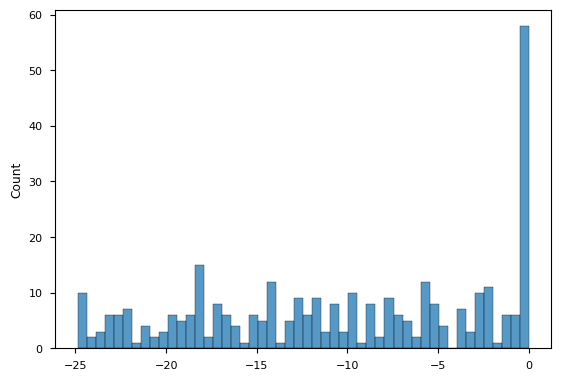

In [ ]:
sns.histplot(np.concat([c.interactions.energies.flatten() for c in circuits]), bins=50)

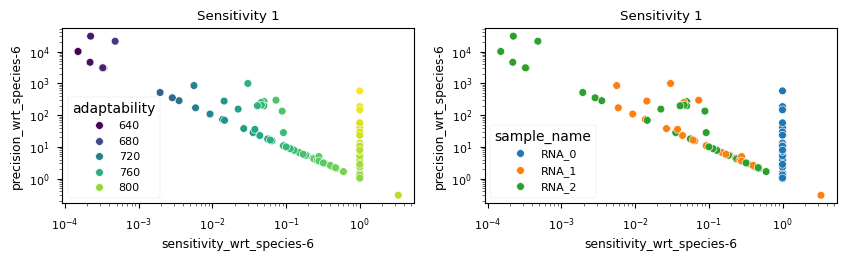

In [ ]:
species_unbound = [s.name for s in circuits[0].get_input_species()]

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(2,2,1)
sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='adaptability', palette='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title('Sensitivity 1')

ax = plt.subplot(2,2,2)
sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
plt.xscale('log')
plt.yscale('log')
plt.title('Sensitivity 1')

if 'sensitivity2_wrt_species-6' in all_df.columns:
    ax = plt.subplot(2,2,3)
    sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivity2_wrt_species-6', y='precision_wrt_species-6', hue='adaptability2', palette='viridis')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Sensitivity 2')

    ax = plt.subplot(2,2,2)
    sns.scatterplot(all_df[all_df['sample_name'].isin(species_unbound)], x='sensitivit2y_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Sensitivity 2')

# Visualise most adaptable circuits

In [ ]:
all_df[(all_df['sensitivity_wrt_species-6'] > 1) & (all_df['sample_name'].isin(species_unbound[1:]))]['name']

7    rand_21
Name: name, dtype: object

In [ ]:
names_circuits_adapting = all_df[all_df['sample_name'].isin(species_unbound[1:])].sort_values('adaptability', ascending=False).iloc[:5]['name'].to_list()
names_circuits_adapting.append(*all_df[(all_df['sensitivity_wrt_species-6'] > 1) & (all_df['sample_name'].isin(species_unbound[1:]))]['name'].to_list())

circuits_adapting = [c for c in circuits if c.name in names_circuits_adapting]

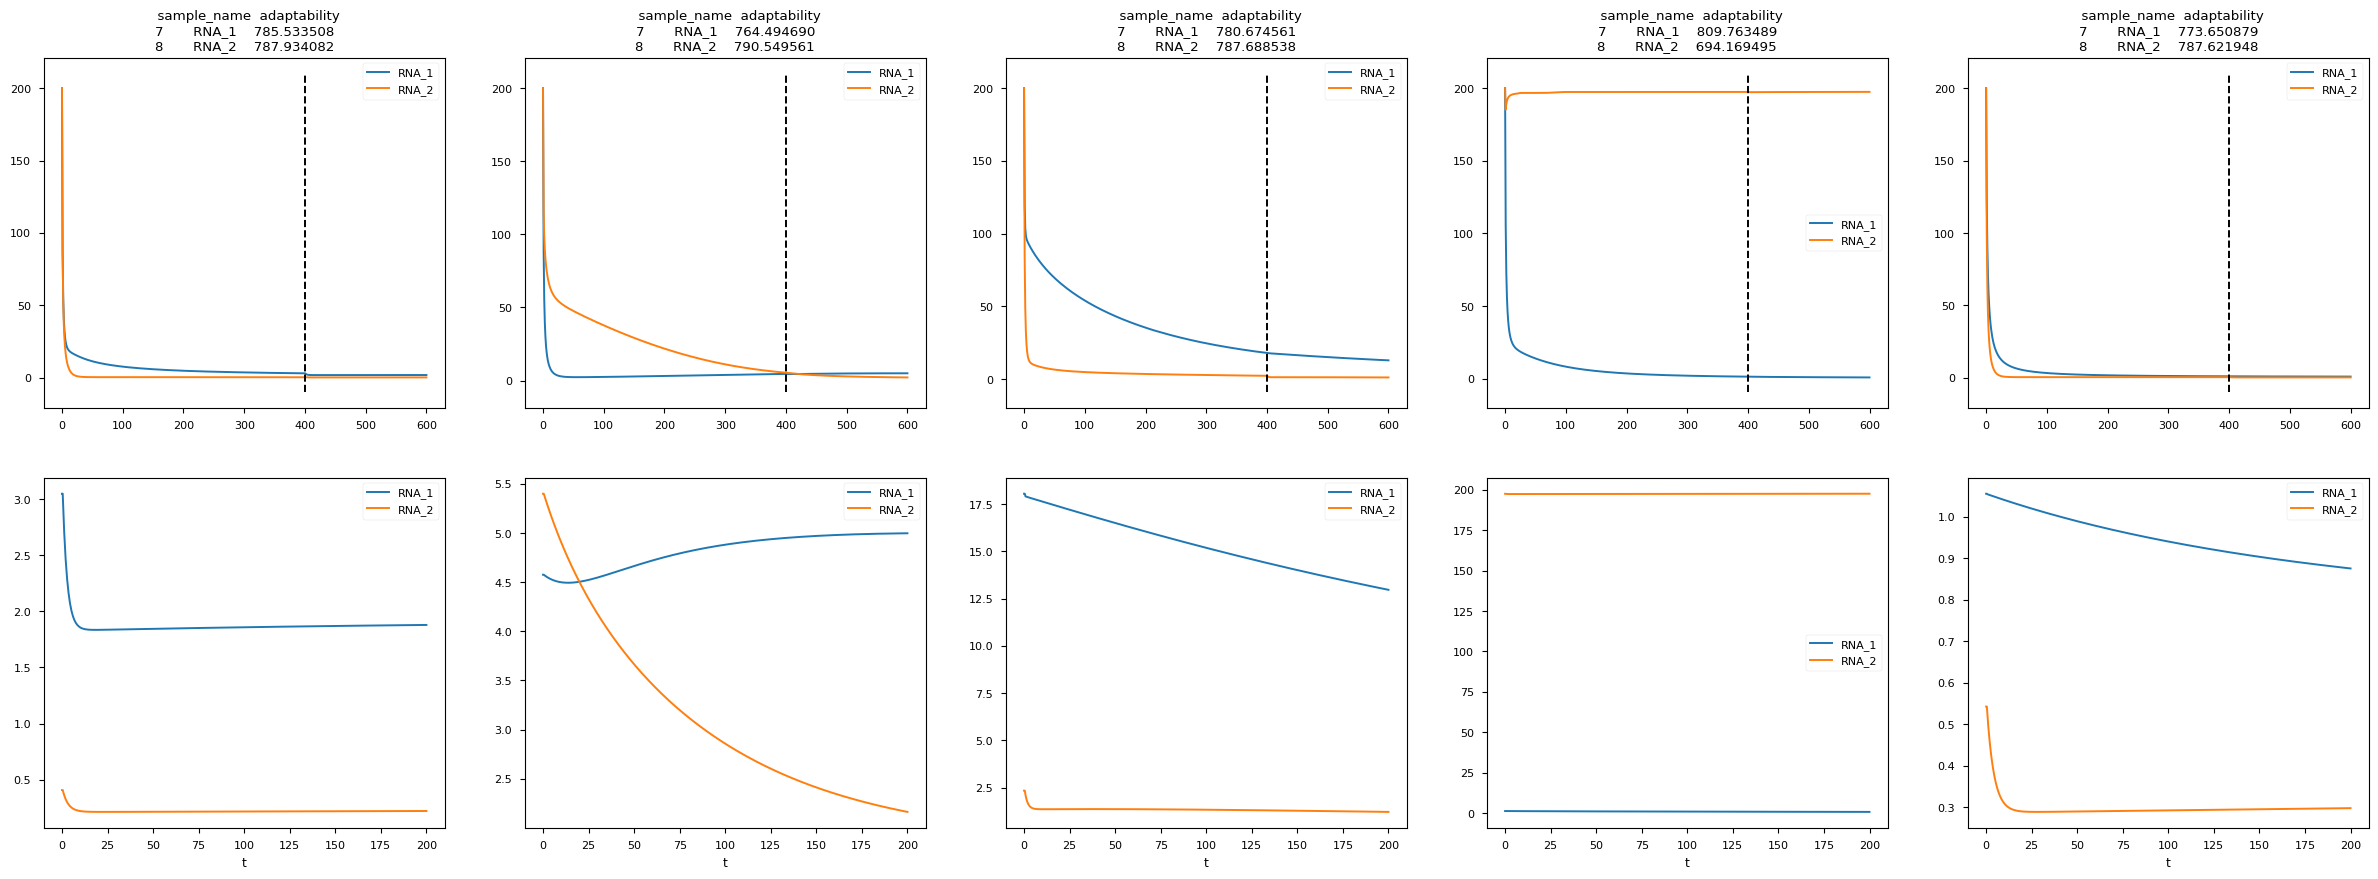

In [ ]:
fig = plt.figure(figsize=(6*len(circuits_adapting),5*2))
# fig, axs = plt.subplots(nrows=2, ncols=len(circuits_adapting), sharex=True, sharey=True)
for i, c in enumerate(circuits_adapting):
    r0 = c.result_collector.get_result('steady_states').vis_kwargs
    r1 = c.result_collector.get_result('signal').vis_kwargs
    ts = np.concat([r0['t'], r1['t'] + r0['t'][-1]])
    y = np.concat([r0['data'].T, r1['data'].T])
    
    ax = plt.subplot(2, len(circuits_adapting), i+1)
    plt.plot(ts, y[:, -2:])
    plt.vlines(x=r0['t'][-1], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linestyle='--')
    plt.legend(r0['legend'][-2:])
    plt.title(all_df[(all_df['name'] == c.name) & all_df['sample_name'].isin(species_unbound[1:])][['sample_name', 'adaptability', 'sensitivity_wrt_species-6', 'precision_wrt_species-6']])
    
    ax = plt.subplot(2, len(circuits_adapting), i+1 + len(circuits_adapting))
    plt.plot(r1['t'], r1['data'].T[:, -2:])
    plt.legend(r0['legend'][-2:])
    plt.xlabel('t')